# Imports

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import time
import torchvision
import torchvision.transforms as transforms
import os
import matplotlib.pyplot as plt
import numpy as np
import shutil
from tqdm import tqdm
import random
import numpy as np
#import cv2
from skimage.util import view_as_windows

# Loading CIFAR10 dataset

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [11]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data_cifar', train=True,
                                        download=True, transform=transform_train)

testset = torchvision.datasets.CIFAR10(root='./data_cifar', train=False,
                                       download=True, transform=transform_test)

batch_size = 128

c, w, h = 3, 32, 32

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batch_size,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=batch_size,
                                         shuffle=True)


Files already downloaded and verified
Files already downloaded and verified


In [12]:
classes_org = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [13]:
# choose a picture at random
im_minibatch, label_minibatch = next(iter(testloader))
im, label = im_minibatch[0].cpu(), label_minibatch[0].cpu()

# store image size dimensions
image_size = tuple(im.shape)

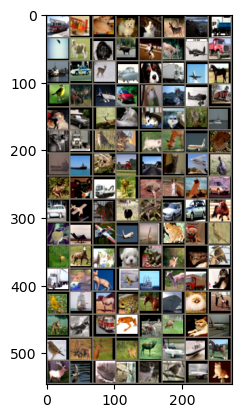

truck plane dog   dog   cat   deer  car   truck plane dog   dog   deer  horse deer  plane truck ship  car   deer  car   dog   truck plane horse bird  deer  plane car   bird  deer  plane truck dog   car   deer  horse cat   ship  cat   ship  cat   truck bird  cat   cat   deer  plane frog  ship  ship  frog  plane truck cat   plane bird  frog  dog   truck deer  frog  horse truck car   car   plane cat   bird  frog  car   car   horse bird  plane plane plane ship  frog  dog   bird  deer  horse horse dog   frog  deer  bird  bird  truck bird  cat   plane ship  deer  truck cat   bird  ship  horse frog  horse ship  dog   horse deer  plane truck frog  deer  deer  cat   plane bird  deer  deer  deer  deer  plane ship  horse deer  bird  ship  deer  deer  bird  plane cat  


In [14]:
# function to show an image
def show(X):    
    if isinstance(X, np.ndarray):
        X = torch.Tensor(X)
                
    X = inverse_transform(X)

    # Clip to valid range for floats
    rgb_data = np.clip(X.numpy(), 0, 1)

    # Clip to valid range for integers
    rgb_data = np.clip(rgb_data, 0, 255)
    
    plt.imshow(np.transpose(rgb_data, (1, 2, 0)))
    plt.show()
    
inverse_transform = transforms.Compose([transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]), 
                                        transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]),])


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
show(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes_org[labels[j]]:5s}' for j in range(batch_size)))

# Loading MobileNetV2 model

In [19]:
def load_model(classes):
    model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=False)

    # Replace the final fully-connected layer
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = torch.nn.Linear(num_ftrs, len(classes))
    
    return model

In [20]:
model_org = load_model(classes_org)
model_org.to(device)
print(model_org)

Using cache found in C:\Users\Frederico/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\Frederico\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Frederico\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

# Training (do not train as it was done and weights are already available)

In [8]:
def train_model(model, trainloader, testloader, weights_dir, num_epochs=200):
    start=time.time()
    
    error = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(0,num_epochs):

        model.train()  # Put the network in train mode
        for i, (x_batch, y_batch) in enumerate(trainloader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move the data to the device that is used

            optimizer.zero_grad()  # Set all currenly stored gradients to zero 

            y_pred = model(x_batch)

            loss = error(y_pred, y_batch)

            loss.backward()

            optimizer.step()

            # Compute relevant metrics

            y_pred_max = torch.argmax(y_pred, dim=1)  # Get the labels with highest output probability

            correct = torch.sum(torch.eq(y_pred_max, y_batch)).item()  # Count how many are equal to the true labels

            elapsed = time.time() - start  # Keep track of how much time has elapsed

            # Show progress every 20 batches 
            if not i % 20:
                print(f'epoch: {epoch}, time: {elapsed:.3f}s, loss: {loss.item():.3f}, train accuracy: {correct / batch_size:.3f}')

        correct_total = 0

        model.eval()  # Put the network in eval mode
        for i, (x_batch, y_batch) in enumerate(testloader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move the data to the device that is used

            y_pred = model(x_batch)
            y_pred_max = torch.argmax(y_pred, dim=1)

            correct_total += torch.sum(torch.eq(y_pred_max, y_batch)).item()

        print(f'Accuracy on the test set: {correct_total / len(testset):.3f}')

        # Save weights every 10 epochs
        if epoch%10==0:
            torch.save(model.state_dict(), f"./{weights_dir}/epoch-{epoch}_accuracy-{correct_total/len(testset):.3f}.pth")
    

In [ ]:
if os.path.exists(os.path.join('weights')):
    shutil.rmtree(os.path.join('weights'))
!mkdir weights

In [ ]:
train_model(model_org, trainloader, testloader, 'weights')

# Load latest weights

In [21]:
def load_weights(classes, model, weights_dir):
    files = os.listdir(weights_dir)
    weight_paths = [os.path.join(weights_dir, basename) for basename in files]
    final_weight_file = os.path.basename(max(weight_paths, key=os.path.getctime))

    model = load_model(classes)

    model.load_state_dict(torch.load(os.path.join(weights_dir, final_weight_file), map_location=device))
    print('Loaded weights: ' + final_weight_file)
    
    return model

In [32]:
model_org = load_weights(classes_org, model_org, 'weights')
model_org.to(device)
# sets the module in eval node
model_org.eval()

Using cache found in C:\Users\Frederico/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\Frederico\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Frederico\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loaded weights: epoch-90_accuracy-0.842.pth


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

# Evaluation

In [565]:
def show_examples(classes, testloader, model):
    dataiter = iter(testloader)
    images, labels = next(dataiter)

    # print images
    show(torchvision.utils.make_grid(images[:16]))
    print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(16)))

    images = images.to(device)
    outputs = model(images)

    _, predicted = torch.max(outputs, 1)

    print('Predicted:   ', ' '.join(f'{classes[predicted[j]]:5s}'
                                  for j in range(16)))

In [14]:
def show_accuracies(classes, testloader, model):
    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # again no gradients needed
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1


    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

    correct_total = 0
    for i, (x_batch, y_batch) in enumerate(testloader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move the data to the device that is used

        y_pred = model(x_batch)
        y_pred_max = torch.argmax(y_pred, dim=1)

        correct_total += torch.sum(torch.eq(y_pred_max, y_batch)).item()

    print(f'\nAccuracy on the test set: {correct_total / len(testset):.3f}')

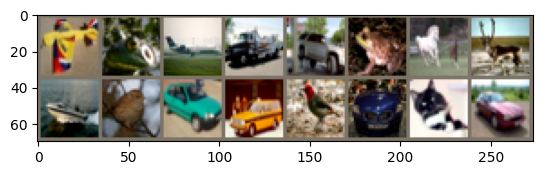

GroundTruth:  plane frog  plane truck car   frog  horse deer  ship  bird  car   car   bird  car   cat   car  
Predicted:    plane frog  plane truck truck frog  dog   deer  ship  bird  car   car   bird  car   dog   car  


In [566]:
show_examples(classes_org, testloader, model_org)

In [567]:
show_accuracies(classes_org, testloader, model_org)

Accuracy for class: plane is 83.6 %
Accuracy for class: car   is 92.3 %
Accuracy for class: bird  is 81.7 %
Accuracy for class: cat   is 64.0 %
Accuracy for class: deer  is 82.9 %
Accuracy for class: dog   is 79.9 %
Accuracy for class: frog  is 86.7 %
Accuracy for class: horse is 86.8 %
Accuracy for class: ship  is 91.0 %
Accuracy for class: truck is 91.0 %

Accuracy on the test set: 0.840


# Adversarial attack

In [54]:
class Optimizer:
    def __init__(self, model, size, group_size=100, cycles=1000, elite_percent=0.8, random_percent=0.05, mutation_rate=0.05,
                 output_level=0, output_interval=50, seed=None, continue_training=False, early_exit=True, tolerance=20):
        self.size = size
        self.group_size = group_size
        self.cycles = cycles
        self.elite_percent = elite_percent
        self.random_percent = random_percent
        self.mutation_rate = mutation_rate
        self.output_level = output_level
        self.output_interval = output_interval
        self.seed = seed
        self.continue_training = continue_training
        self.early_exit = early_exit
        self.tolerance = tolerance
        self.model = model
        self.population = None

    def optimize(self, evaluation_fn, cycles=-1, output_interval=None):
        if output_interval is None:
            output_interval = self.output_interval
        if self.seed is not None:
            np.random.seed(self.seed)
        if self.population is None or self.continue_training:
            self.population = self._create_population(self.size)
    
        if cycles != -1:
            self.cycles = cycles
    
        results = np.zeros(len(self.population))
        prev_results = np.zeros(len(self.population))
        no_change_count = 0

        for iteration in range(self.cycles):
            self.population, results = self._evolve(evaluation_fn)
            if np.isclose(prev_results[:10], results[:10]).all():
                no_change_count += 1
            else:
                no_change_count = 0
                prev_results = results
            
            if self.output_level:
                if iteration == 0:
                    print("Iteration #: best result")
                elif iteration == self.cycles - 1:
                    print("Iteration ",iteration,": ",results[0])
                elif iteration % output_interval == 0:
                    print("Iteration ",iteration,": ",results[0])
                    
            if np.isclose(results[:10], 1).any() or (self.early_exit and no_change_count >= self.tolerance):
                if self.output_level:
                    print("Early exit on iteration ",iteration, " with best result ", results[0])
                break

        return self.population[0], results[0]

    def _create_population(self, size):
        """
        Creating initial population of individual solutions
        """
        return np.random.rand(self.group_size, *size)


    def _evolve(self, evaluation_fn):
        """
        Evolving the population to the next generation
        """
        scores = self.evaluate_population(self.population, evaluation_fn)

        elite_size = int(self.elite_percent * self.group_size)
        elite_indices = np.argsort(scores)[-elite_size:]
        elite = [self.population[i] for i in elite_indices]

        random_size = int(self.random_percent * self.group_size)
        random_indices = np.random.randint(0, self.group_size, random_size)
        random_population = [self.population[i] for i in random_indices]

        children = []
        while len(children) < self.group_size - elite_size - random_size:
            mom_idx, dad_idx = np.random.randint(0, elite_size - random_size - 1, 2)
            parent1 = self.population[mom_idx]
            parent2 = self.population[dad_idx]
            
            child = self._crossover(parent1, parent2)

            #child = self.crossover(parents[mom_idx], parents[dad_idx], self.image_size)

            if np.random.random() < self.mutation_rate:
                child = self._mutate(child)
            children.append(child)

        next_population = elite + random_population + children
        return next_population, scores

    def _crossover(self, parent1, parent2):
        """
        Crossover operation
        """
        point = np.random.randint(0, len(parent1))
        return np.concatenate((parent1[:point], parent2[point:]))

    def _mutate(self, child):
        """
        Mutation operation
        """
        point = np.random.randint(0, len(child))
        child[point] = np.random.randint(0, 255)
        return child
    
    def evaluate_population(self, population, fitness_function):
        """
        Apply evaluation function for each gene in a population
        :param population: list of candidate solutions (images)
        :return: list/1d-array of scores for each solution
        """
        if type(population) is list:
            population = np.array(population)
            
        return fitness_function(population, self.model)


In [34]:
def fitness_class_probability_empty(X, model):
    """ Maximize probability of adversarial target class, penalizing mean pixel intensity"""
    y = model(torch.Tensor(X).to(device)).to('cpu').detach().numpy()
    y_target = y[:, adv_target]
    X_mean = X.mean(axis=1).mean(axis=1).mean(axis=1)
    a = y_target - X_mean
    return y_target - X_mean

In [35]:
# NOT WORKING

def fitness_similarity(X, model):
    """ Maximize adv_target probability while MSE from adv_sample """
    # Convert image to grayscale
    gray_images = (X[:,0]+X[:,1]+X[:,2])/3
    gray_images = np.expand_dims(gray_images, axis=1)  
    y = model(torch.Tensor(X).to(device)).to('cpu').detach().numpy()

    y_target = y[:, adv_target]
    gray_adv_sample = (adv_sample[:,0]+adv_sample[:,1]+adv_sample[:,2])/3
    gray_adv_sample = np.expand_dims(gray_adv_sample, axis=1)  
    mse = np.sqrt(np.power(gray_images - gray_adv_sample, 2).mean(axis=1).mean(axis=1).mean(axis=1))
    a = y_target - mse

    return y_target - mse


In [36]:
def show_probabilities(X, model, classes):
    if isinstance(X, np.ndarray):
        X = torch.Tensor(X)
    prob = F.softmax(model(X.unsqueeze(0).to(device)), dim=1)

    print('Confidence scores:\n' + '\n'.join(['{}: {}'.format(classes[i], p.item()) for i, p in enumerate(prob.squeeze())]))    
    print('\nLabel with highest confidence score: {}'.format(classes[torch.argmax(prob).item()]))

## Attack with a single sample

In [50]:
def attack(classes, attack_class, model, cycles=1000):
    adv_target = classes.index(attack_class)
    m = Optimizer(model, size=image_size, output_level=True, output_interval=100, continue_training=True, early_exit=False)
    res, score = m.optimize(fitness_class_probability_empty, cycles=cycles, output_interval=500)
    return res


In [55]:
generated_sample = attack(classes_org, 'frog', model_org)

Iteration #: best result
Iteration  500 :  5.53798208289852
Iteration  999 :  5.53798208289852


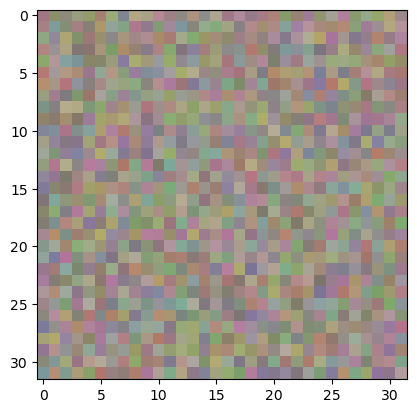

Confidence scores:
plane: 3.3094582363446534e-07
car: 4.170600504949107e-07
bird: 0.0008712820126675069
cat: 0.0001276942784897983
deer: 0.0030095011461526155
dog: 1.4164126014293288e-06
frog: 0.9959885478019714
horse: 3.425477075325034e-07
ship: 5.925072343870852e-08
truck: 3.4094193779310444e-07

Label with highest confidence score: frog

~~~Attack was successful!~~~


In [56]:
show(generated_sample)
show_probabilities(generated_sample, model_org, classes_org)

print('\n~~~Attack was successful!~~~')

## Generating a dataset of adversarial examples

In [22]:
generate_adversarial_dataset = False

if generate_adversarial_dataset:
    if os.path.exists(os.path.join('adversarial_dataset')):
        shutil.rmtree(os.path.join('adversarial_dataset'))
    !mkdir adversarial_dataset

In [30]:
# set number of images to generate per class
numImgsPerClass = 600

In [ ]:
noise_data = []

for aClass in classes_org:
    print('Generating adversarial examples for class: ' + aClass)
    
    for i in tqdm(range(0,numImgsPerClass)):
        generated_img = attack(classes_org, aClass, model_org)
        noise_data.append((torch.Tensor(generated_img), torch.as_tensor(10)))

In [ ]:
if generate_adversarial_dataset:
    # Save the noise data to a file
    torch.save(noise_data, 'adversarial_dataset/noise_data.pt')

# Adversarial defence

## Method 1: Training on generated adversarial images

## Creating new dataset with adversarial examples

In [36]:
noise_data = torch.load('adversarial_dataset/noise_data.pt')

In [37]:
random.shuffle(noise_data)
noise_data_train = noise_data[:5000]
noise_data_test = noise_data[5000:]

In [38]:
cifar_data_train = []
cifar_data_test = []

for images, labels in trainloader:
    for image, label in zip(images, labels):
        cifar_data_train.append((image, label))
        
for images, labels in testloader:
    for image, label in zip(images, labels):
        cifar_data_test.append((image, label))

In [39]:
combined_data_train = noise_data_train + cifar_data_train
combined_data_test = noise_data_test + cifar_data_test

In [40]:
class CombinedDataset(Dataset):
    def __init__(self, combined_data):
        self.combined_data = combined_data

    def __len__(self):
        return len(self.combined_data)

    def __getitem__(self, idx):
        return self.combined_data[idx]

batch_size = 128
    
combined_dataset_train = CombinedDataset(combined_data_train)
combined_dataset_test = CombinedDataset(combined_data_test)
combined_dataloader_train = DataLoader(combined_dataset_train, batch_size=batch_size, shuffle=True)
combined_dataloader_test = DataLoader(combined_dataset_test, batch_size=batch_size, shuffle=True)

## Create new model for training

In [41]:
# MobileNetV2 needs to be trained now on 11 classes

In [42]:
classes_adv = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck', 'generated')

In [43]:
model_adv = load_model(classes_adv)
model_adv.to(device)
print(model_adv)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

Using cache found in C:\Users\raulv/.cache\torch\hub\pytorch_vision_v0.10.0


## Adversarial training (do not train as it was done and weights are already available)

In [34]:
if os.path.exists(os.path.join('adversarial_weights')):
    shutil.rmtree(os.path.join('adversarial_weights'))
!mkdir adversarial_weights

In [ ]:
train_model(model_adv, combined_dataloader_train, combined_dataloader_test, 'adversarial_weights')

## Evaluation of adversarially trained model

In [44]:
model_adv = load_weights(classes_adv, model_adv, 'adversarial_weights')
model_adv.to(device)
# sets the module in eval node
model_adv.eval()

Using cache found in C:\Users\raulv/.cache\torch\hub\pytorch_vision_v0.10.0


Loaded weights: epoch-190_accuracy-0.785.pth


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

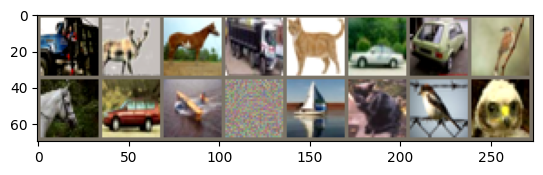

GroundTruth:  truck deer  horse truck cat   car   car   bird  horse car   plane generated ship  cat   bird  bird 
Predicted:    truck deer  horse truck dog   car   car   bird  bird  car   deer  generated plane dog   bird  bird 


In [572]:
show_examples(classes_adv, combined_dataloader_test, model_adv)

### Attacking using generated images based on original model **(model_org)**

In [573]:
# Generate based on original model
generated_frog = attack(classes_adv, 'frog', model_org)

Generation #: best score
Generation  500 :  16.99108856994879
Generation  999 :  17.594540605080965


In [574]:
# Pass images generated on model_org to model_adv for detection
show_probabilities(generated_frog, model_adv, classes_adv)

Confidence scores:
plane: 0.0
car: 0.0
bird: 0.0
cat: 0.0
deer: 0.0
dog: 0.0
frog: 0.0
horse: 0.0
ship: 0.0
truck: 0.0
generated: 1.0

Label with highest confidence score: generated


In [575]:
show_accuracies(classes_adv, combined_dataloader_test, model_adv)
print("\n~~~Overall accuracy is decreased. However, all generated images based on original model are now detected!~~~")

Accuracy for class: plane is 76.3 %
Accuracy for class: car   is 85.7 %
Accuracy for class: bird  is 61.8 %
Accuracy for class: cat   is 44.2 %
Accuracy for class: deer  is 63.5 %
Accuracy for class: dog   is 52.4 %
Accuracy for class: frog  is 80.8 %
Accuracy for class: horse is 69.4 %
Accuracy for class: ship  is 79.7 %
Accuracy for class: truck is 71.5 %
Accuracy for class: generated is 100.0 %

Accuracy on the test set: 0.785

~~~Overall accuracy is decreased. However, all generated images based on original model are now detected!~~~


### Attacking using generated images based on new adversarially trained model **(model_adv)**

In [576]:
# Generate based on new model
generated_frog = attack(classes_adv, 'frog', model_adv)

Generation #: best score
Generation  500 :  10.29395055302565
Generation  999 :  11.079147288569354


In [577]:
show_probabilities(generated_frog, model_adv, classes_adv)
print("\n~~~Model has been fooled again after it was trained to detect generated images. Newly generated images on model_adv learned to bypass adversarial training!~~~")

Confidence scores:
plane: 6.240439438576961e-23
car: 2.239557934567196e-22
bird: 5.180485481107855e-20
cat: 7.03985229028606e-16
deer: 2.7388360363214573e-17
dog: 2.7480232418718693e-18
frog: 1.0
horse: 1.4369172322973328e-21
ship: 5.0153476035552306e-23
truck: 8.461326108368407e-22
generated: 3.466728322831738e-40

Label with highest confidence score: frog

~~~Model has been fooled again after it was trained to detect generated images. Newly generated images on model_adv learned to bypass adversarial training!~~~


### So, adversarial training does not work on images generated using adversarial model. It works only with images generated using original model :(

## Method 2: Data pre-processing

## Finding minimum std of pixel regions in image

In [578]:
def find_min_std(img):
    if isinstance(img, torch.Tensor):
        img = img.numpy()

    # Load the image and convert it to grayscale
    image = np.transpose(img, (1, 2, 0))
    image_8u = cv2.convertScaleAbs(image, alpha=255)
    gray_image = cv2.cvtColor(image_8u, cv2.COLOR_BGR2GRAY)

    # Define the patch size and overlap
    patch_size = (3, 3)
    overlap = (1, 1)

    # Compute the grid of patches
    patches = view_as_windows(gray_image, patch_size, overlap)

    # Compute the standard deviation of the pixel intensities in each patch
    patch_stds = np.std(patches, axis=(-1, -2))

    return min(np.array(patch_stds).flatten().tolist())

In [371]:
# NOT USED NOW

def frequency_domain_detection(image: torch.Tensor) -> float:
    # Convert the image to numpy array
    image = image.numpy().transpose(1,2,0)
    image_8u = cv2.convertScaleAbs(image, alpha=255)

    # Convert image to grayscale
    gray_image = cv2.cvtColor(image_8u, cv2.COLOR_RGB2GRAY)
    # perform FFT on grayscale image
    fft_image = np.fft.fft2(gray_image)
    # shift the FFT to center
    fft_image = np.fft.fftshift(fft_image)
    # calculate the mean of the magnitude
    std = np.std(np.abs(fft_image))
    return std

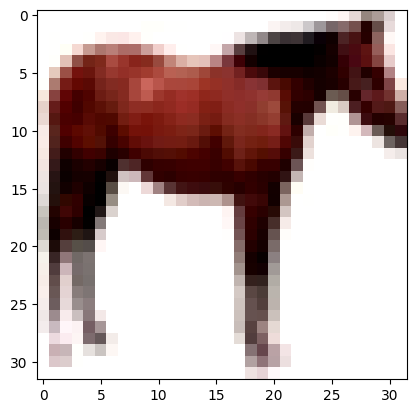

Patch of pixels with smallest std = 0.0


In [579]:
show(cifar_data_test[0][0])
print('Patch of pixels with smallest std =', str(find_min_std(cifar_data_test[0][0])))

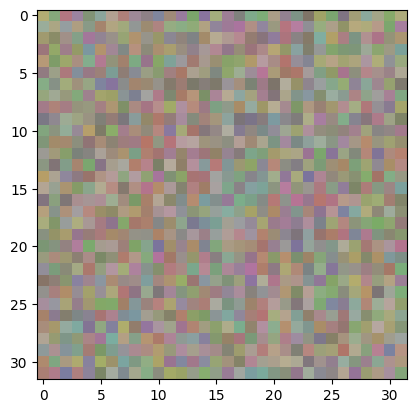

Patch of pixels with smallest std = 16.79947089113887


In [580]:
show(noise_data[0][0])
print('Patch of pixels with smallest std =', str(find_min_std(noise_data[0][0])))

In [581]:
stds = []
for data in cifar_data_train+cifar_data_test:
    stds.append(find_min_std(data[0]))

print('Minimum min std of all samples in CIFAR10 dataset: ' + str(min(stds)))
print('Maximum min std of all samples in CIFAR10 dataset: ' + str(max(stds)))
    
stds = []
for data in noise_data:
    stds.append(find_min_std(data[0]))

print('Minimum min std of all samples in noise_data: ' + str(min(stds)))
print('Maximum min std of all samples in noise_data: ' + str(max(stds)))

Minimum min std of all samples in CIFAR10 dataset: 0.0
Maximum min std of all samples in CIFAR10 dataset: 13.314801936840215
Minimum min std of all samples in noise_data: 3.8999841721742765
Maximum min std of all samples in noise_data: 24.632609120813115


In [ ]:
# TODO: OVERLAP BETWEEN 3.89 AND 13.31, NOT ALL SAMPLES ARE FOUND USING THIS METHOD

In [604]:
print(str(60000 - len([1 for data in cifar_data_train+cifar_data_test if find_min_std(data[0])<3])) + ' samples from CIFAR10 are going to be incorrectly labeled as generated by data pre-processing')

447 samples from CIFAR10 are going to be incorrectly labeled as generated by data pre-processing


In [617]:
class CustomMobileNetV2(torch.nn.Module):
    def __init__(self):
        super(CustomMobileNetV2, self).__init__()
        self.model = load_model(classes_org)
        self.model = load_weights(classes_org, self.model, 'weights')
        
    def forward(self, x):
        # Pass the image through the model and return the predicted label
        with torch.no_grad():
            logits = self.model(x)
            
            # create a tensor of -1000 with shape (batch_size,1)
            generated_label = torch.full((x.shape[0],1),-1000,dtype=x.dtype, device=device)

            # concatenate the logits and generated_label along the second dimension
            logits = torch.cat((logits, generated_label), dim=1)

            for i in range(x.shape[0]):
                min_std = find_min_std(x[i].squeeze(0).cpu())
                if min_std > 3.0:
                    logits[i] = torch.tensor([-1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, 1], dtype=x.dtype, device=device)

            return logits

# Wrap the model in a CustomModel object
model_preprocessing = CustomMobileNetV2()
model_preprocessing.to(device)
model_preprocessing.eval()

Using cache found in C:\Users\raulv/.cache\torch\hub\pytorch_vision_v0.10.0
Using cache found in C:\Users\raulv/.cache\torch\hub\pytorch_vision_v0.10.0


Loaded weights: epoch-190_accuracy-0.840.pth


CustomMobileNetV2(
  (model): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_siz

In [583]:
# Generate based on original model
generated_frog_org = attack(classes_adv, 'frog', model_org)

Generation #: best score
Generation  500 :  16.649572526654214
Generation  999 :  17.263987705251722


In [218]:
# Generate based on adversarially trained model
generated_frog_adv = attack(classes_adv, 'frog', model_adv)

Generation #: best score
Generation  500 :  9.116175462809654
Generation  999 :  10.455163210201913


In [618]:
print('Results for a real image:')
show_probabilities(images[0], model_preprocessing, classes_adv)

print('\nResults for generated image on model_org:')
show_probabilities(generated_frog_org, model_preprocessing, classes_adv)

print('\nResults for generated image on model_adv:')
show_probabilities(generated_frog_adv, model_preprocessing, classes_adv)

print('\n~~~Data pre-processing manages to find generated adversarial images based on both model_org and model_adv!~~~')

Results for a real image:
Confidence scores:
plane: 2.5099172740183917e-11
car: 1.311598052389229e-10
bird: 3.068232899750001e-06
cat: 0.0001152431286755018
deer: 2.554997138304316e-07
dog: 2.1553905327209577e-09
frog: 0.999881386756897
horse: 2.1050018672585935e-10
ship: 1.542434291401662e-09
truck: 1.1751585482500104e-08
generated: 0.0

Label with highest confidence score: frog

Results for generated image on model_org:
Confidence scores:
plane: 0.0
car: 0.0
bird: 0.0
cat: 0.0
deer: 0.0
dog: 0.0
frog: 0.0
horse: 0.0
ship: 0.0
truck: 0.0
generated: 1.0

Label with highest confidence score: generated

Results for generated image on model_adv:
Confidence scores:
plane: 0.0
car: 0.0
bird: 0.0
cat: 0.0
deer: 0.0
dog: 0.0
frog: 0.0
horse: 0.0
ship: 0.0
truck: 0.0
generated: 1.0

Label with highest confidence score: generated

~~~Data pre-processing manages to find generated adversarial images based on both model_org and model_adv!~~~


In [620]:
show_accuracies(classes_adv, combined_dataloader_test, model_preprocessing)

Accuracy for class: plane is 83.3 %
Accuracy for class: car   is 92.3 %
Accuracy for class: bird  is 79.1 %
Accuracy for class: cat   is 63.8 %
Accuracy for class: deer  is 76.5 %
Accuracy for class: dog   is 79.4 %
Accuracy for class: frog  is 81.1 %
Accuracy for class: horse is 86.8 %
Accuracy for class: ship  is 90.9 %
Accuracy for class: truck is 90.8 %
Accuracy for class: generated is 100.0 %

Accuracy on the test set: 0.924


## Will genetic algorithm bypass model with data pre-processing when it is attacked directly?

In [610]:
# Generate based on data pre-processing model
generated_frog = attack(classes_adv, 'frog', model_preprocessing)

Generation #: best score
Generation  500 :  -1000.301570843016
Generation  999 :  -1000.2497167911156


In [612]:
_, res = torch.max(model_preprocessing(torch.Tensor(generated_frog).unsqueeze(0).to(device)),1)
print('Classification: ' + classes_adv[res.item()])

Classification: generated


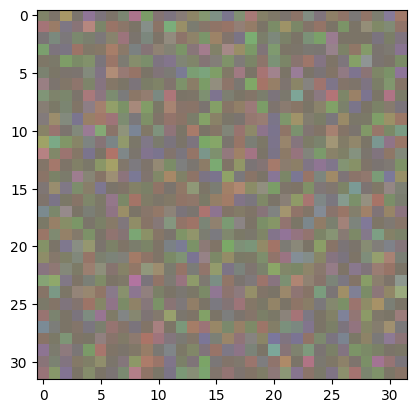

In [616]:
show(generated_frog)